<a href="https://colab.research.google.com/github/GitanDas/Corrosion-Detection-Model/blob/main/Copy_of_Corrosion_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
for dirname, _, filenames in os.walk('drive/MyDrive/download'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

drive/MyDrive/download/.floyddata
drive/MyDrive/download/norust/norust.16.jpg
drive/MyDrive/download/norust/norust.0.jpg
drive/MyDrive/download/norust/norust.15.jpg
drive/MyDrive/download/norust/norust.2.jpg
drive/MyDrive/download/norust/norust.19.jpg
drive/MyDrive/download/norust/norust.13.jpg
drive/MyDrive/download/norust/norust.1.jpg
drive/MyDrive/download/norust/norust.14.jpg
drive/MyDrive/download/norust/norust.17.jpg
drive/MyDrive/download/norust/norust.10.jpg
drive/MyDrive/download/norust/norust.12.jpg
drive/MyDrive/download/norust/norust.11.jpg
drive/MyDrive/download/norust/norust.18.jpg
drive/MyDrive/download/norust/norust.22.jpg
drive/MyDrive/download/norust/norust.35.jpg
drive/MyDrive/download/norust/norust.20.jpg
drive/MyDrive/download/norust/norust.34.jpg
drive/MyDrive/download/norust/norust.31.jpg
drive/MyDrive/download/norust/norust.38.jpg
drive/MyDrive/download/norust/norust.32.jpg
drive/MyDrive/download/norust/norust.25.jpg
drive/MyDrive/download/norust/norust.3.jpg
dr

In [ ]:
import torchvision
import torch
import matplotlib.pyplot as plt
from torch.utils.data import random_split

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
DATA_DIR = 'drive/MyDrive/download'

In [ ]:
!ls '{DATA_DIR}' | head

norust
rust


In [ ]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torchvision.transforms import ToTensor

In [ ]:
transformations_exp = transforms.Compose([
    transforms.Resize((256,256)),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalise([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])

])

In [ ]:
dataset = ImageFolder(DATA_DIR, transform = transformations_exp)

In [ ]:
print(dataset.classes)

['norust', 'rust']


In [ ]:
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 224, 224]) 0


tensor([[[-1.1760, -1.2617, -1.3473,  ..., -0.1657, -0.0629, -0.3541],
         [-0.8164, -0.9020, -0.9877,  ..., -0.2513, -0.1657, -0.2684],
         [-0.2684, -0.4054, -0.5424,  ..., -0.3198, -0.2342, -0.3027],
         ...,
         [-0.0629, -0.2342, -0.3883,  ...,  0.4166,  0.3309,  0.3994],
         [ 0.4166,  0.1768,  0.0056,  ...,  0.4337,  0.4337,  0.3309],
         [ 0.7591,  0.6221,  0.4679,  ...,  0.5193,  0.4851,  0.5022]],

        [[-1.0378, -1.1253, -1.2129,  ..., -0.0224,  0.0826, -0.1975],
         [-0.6702, -0.7577, -0.8452,  ..., -0.1275, -0.0224, -0.1099],
         [-0.1099, -0.2500, -0.3901,  ..., -0.1975, -0.0924, -0.1450],
         ...,
         [ 0.0651, -0.1099, -0.2675,  ...,  0.5378,  0.4503,  0.5203],
         [ 0.5553,  0.3102,  0.1352,  ...,  0.5553,  0.5553,  0.4503],
         [ 0.9055,  0.7654,  0.6078,  ...,  0.6429,  0.6078,  0.6254]],

        [[-0.8284, -0.9156, -1.0027,  ...,  0.1999,  0.3219, -0.0092],
         [-0.4624, -0.5495, -0.6367,  ...,  0

In [ ]:
test_size = 50
train_size = len(dataset) - test_size
train_ds, test_ds = random_split(dataset, [train_size,test_size])
len(train_ds),len(test_ds)

(105, 50)

In [ ]:
from torch.utils.data.dataloader import DataLoader
batch_size = 20

In [ ]:
train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle = True,
                      pin_memory = True)
test_dl = DataLoader(test_ds,
                     batch_size*2,
                     shuffle=False,
                     pin_memory = True)

In [ ]:
from torchvision.utils import make_grid
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize = (12,6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 10).permute(1,2,0))
        break

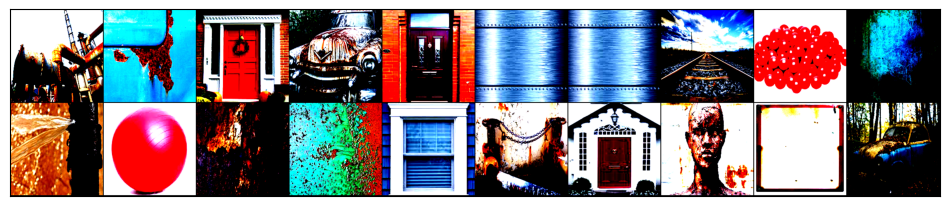

In [ ]:
show_batch(train_dl)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
class Corrosion_Detection(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            # imput : 3 x 224 x 224
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            # output : 32 x 224 x 224
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 112 x 112

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 56 x 56

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 28 x 28

            nn.Flatten(),
            nn.Linear(256*28*28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 2))

    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = Corrosion_Detection()
model

Corrosion_Detection(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=200704, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(i

In [ ]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [ ]:
model = model.to(device)

In [ ]:
@torch.no_grad()# The @ does not allow tracking of gradients
def evaluate(model, test_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in test_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, test_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Testing phase
        result = evaluate(model, test_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

model = to_device(Corrosion_Detection(), device)

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.0001

In [ ]:
history = fit(num_epochs, lr, model, train_dl, test_dl, opt_func)

Epoch [0], train_loss: 0.6982, val_loss: 0.6864, val_acc: 0.5750
Epoch [1], train_loss: 0.6872, val_loss: 0.6689, val_acc: 0.6875
Epoch [2], train_loss: 0.6432, val_loss: 0.6013, val_acc: 0.7000
Epoch [3], train_loss: 0.6619, val_loss: 0.5610, val_acc: 0.7125
Epoch [4], train_loss: 0.4913, val_loss: 0.5215, val_acc: 0.7500
Epoch [5], train_loss: 0.4150, val_loss: 0.3804, val_acc: 0.8250
Epoch [6], train_loss: 0.3585, val_loss: 0.3849, val_acc: 0.8500
Epoch [7], train_loss: 0.3562, val_loss: 0.2446, val_acc: 0.8750
Epoch [8], train_loss: 0.2144, val_loss: 0.4484, val_acc: 0.8000
Epoch [9], train_loss: 0.2395, val_loss: 0.2315, val_acc: 0.9125


In [ ]:
def plot_accuracies(history):
  accuracies = [x['val_acc'] for x in history]
  plt.plot(accuracies, '-x')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title('Accuracy vs No. of Epochs');

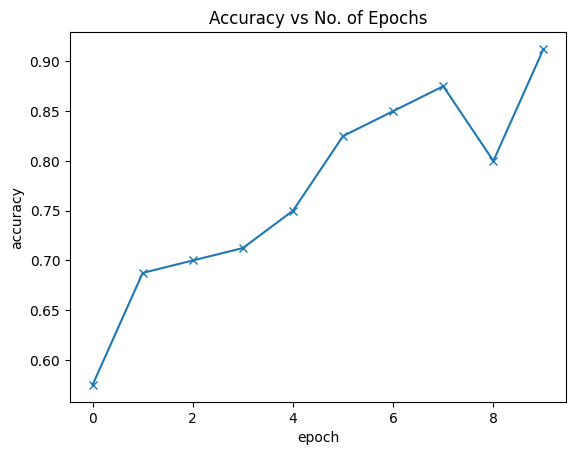

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
  train_losses = [x.get('train_loss') for x in history]
  val_losses = [x.get('val_loss') for x in history]
  plt.plot(val_losses, '-rx')
  plt.plot(train_losses, '-bx')
  plt.xlabel('epoch')
  plt.ylabel(['Validation', 'Training'])
  plt.title('Loss vs NO. of Epochs')

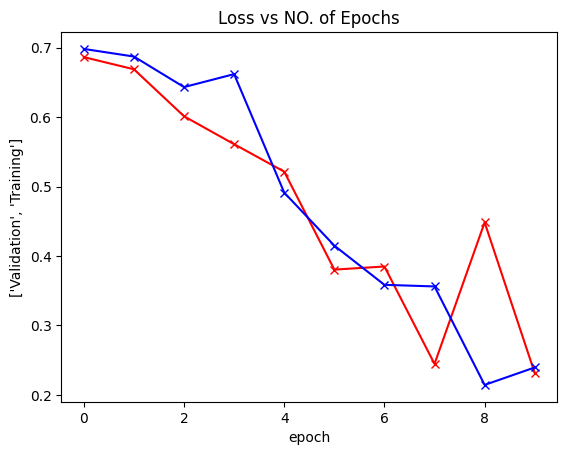

In [ ]:
plot_losses(history)

# New Section

In [ ]:
torch.save(model.state_dict(), 'Corrosion_Detection.pth')

In [ ]:
import torch
import cv2
import torchvision.transforms as transforms

In [ ]:
def predict_single(image, model):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    # print("Prediction: ", prediction[0].item())
    prediction = preds[0]
    a = prediction[0].item()
    b = prediction[1].item()
    if a>b :
        print("No corrosion")
    else:
        print("Corrosion")
    plt.imshow(image.cpu().permute(1, 2, 0))


In [ ]:
path = '/content/drive/MyDrive/Corrosion_Detection.pth'
model = Corrosion_Detection()
model.load_state_dict(torch.load(path))
model.eval()

Corrosion_Detection(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=200704, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(i

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


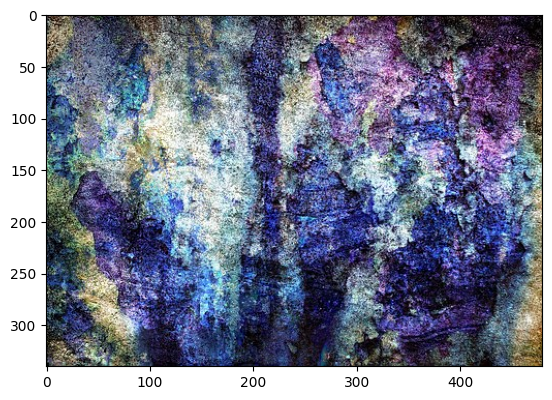

In [ ]:
# image = cv2.imread('drive/MyDrive/download/norust/norust.9.jpg')
image = cv2.imread('drive/MyDrive/download/rust/rust.0.jpg')
# print(type(image))
plt.imshow(image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
og_image = image
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256,256)),
        transforms.CenterCrop(size=224),
        transforms.Normalize([0.485, 0.456, 0.406],
                            [0.229, 0.224, 0.225])

])

tensor = transform(image)

Corrosion


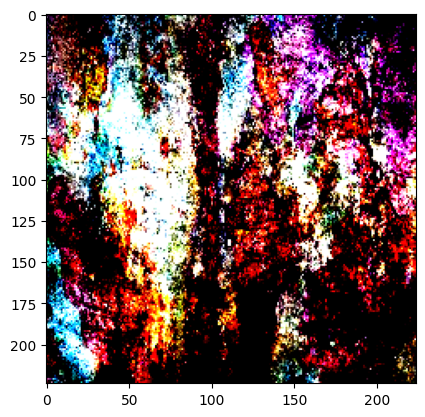

In [ ]:
# predict_single(test_ds[10][0])
# predict_single(tensor)
# test_dataset = to_device(test_dataset, device)
tensor = tensor.to(device)
predict_single(tensor, model)

In [ ]:
test_ds[10][0]

tensor([[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         ...,
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],

        [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         ...,
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],

        [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
         [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
         [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.